In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.display
import numpy as np
import json

from src.data import NSynthDataset
from src.utils import print_and_log

/home/ec2-user/.local/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
class Autoencoder(nn.Module):
    def __init__(self, h_dim=128):
        super(Autoencoder, self).__init__()
        
        # (1, 128, 251)
        self.conv1 = nn.Conv2d(1, 32, 4, padding=(1, 4), stride=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, 4, padding=1, stride=(2, 2))
        self.conv3 = nn.Conv2d(64, 128, 4, padding=1, stride=(2, 2))
        self.conv4 = nn.Conv2d(128, 256, 4, padding=1, stride=(2, 2))
        self.conv5 = nn.Conv2d(256, 512, 4, padding=1, stride=(2, 2))

        self.fc_enc = nn.Linear(512*4*8, h_dim, bias=True)
        self.fc_dec = nn.Linear(h_dim, 512*4*8, bias=True)

        self.deconv1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.deconv5 = nn.ConvTranspose2d(32, 1, (2, 3), padding=(0, 3), stride=2)
        
        # (1, 40, 126)
#         self.conv1 = nn.Conv2d(1, 32, 4, padding=1, stride=(2, 2))
#         self.conv2 = nn.Conv2d(32, 64, 4, padding=1, stride=(2, 2))
#         self.conv3 = nn.Conv2d(64, 128, 4, padding=1, stride=(2, 2))
#         self.conv4 = nn.Conv2d(128, 256, 4, padding=1, stride=(2, 2))
        
#         self.fc_enc = nn.Linear(3584, h_dim, bias=True)
#         self.fc_dec = nn.Linear(h_dim, 3584, bias=True)

#         self.deconv1 = nn.ConvTranspose2d(256, 128, 3, stride=2)
#         self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 3), stride=2)
#         self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 3), stride=2)
#         self.deconv4 = nn.ConvTranspose2d(32, 1, 2, stride=2)
        
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
    
        x = x.view(x.size(0), -1)
        return F.relu(self.fc_enc(x))
        
    def decode(self, z):
        h = F.relu(self.fc_dec(z))
        h = h.view(h.size(0), 512, 4, 8)
        
        h = F.relu(self.deconv1(h))
        h = F.relu(self.deconv2(h))
        h = F.relu(self.deconv3(h))
        h = F.relu(self.deconv4(h))
        h = self.deconv5(h)
        return torch.sigmoid(h)
        
    def forward(self, x):
        z = self.encode(x)
        outputs = self.decode(z)
        return outputs

In [3]:
hparams = {
    'feature_type' : 'mel',
    'instrument_source' : [0],
    'scaling' : 'normalize',
    'n_epochs' : 25,
    'batch_size' : 32,
    'lr' : 0.001,
    'hidden_dim' : 128,
    'display_iters' : 10,
    'val_iters' : 100,
    'n_val_samples' : 1000,
    'n_early_stopping' : 5 # stop if validation doesn't improve after this number of validation cycles
}

In [4]:
train_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-train', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling']
)

val_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-valid', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling']
)

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [9]:
model = Autoencoder(h_dim=hparams['hidden_dim'])

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

In [ ]:
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')
results_dir = 'train_results/autoencoder/{}'.format(timestamp)
os.makedirs(results_dir)

with open(os.path.join(results_dir, 'hparams.json'), 'w') as fp:
    json.dump(hparams, fp)

log_file = os.path.join(results_dir, 'train_log.txt')
log = open(log_file, 'w')
log.close()

[0,     1] loss : 0.5357
[0,    10] loss : 0.1107
[0,    20] loss : 0.0540
[0,    30] loss : 0.0250
[0,    40] loss : 0.0229
[0,    50] loss : 0.0233
[0,    60] loss : 0.0214
[0,    70] loss : 0.0225
[0,    80] loss : 0.0168
[0,    90] loss : 0.0217
[0,   100] loss : 0.0262
Val - loss : 0.0280


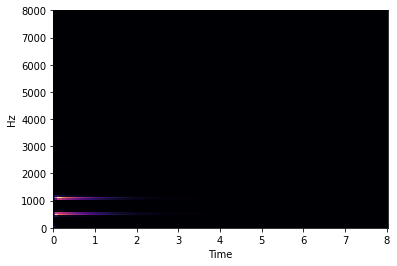

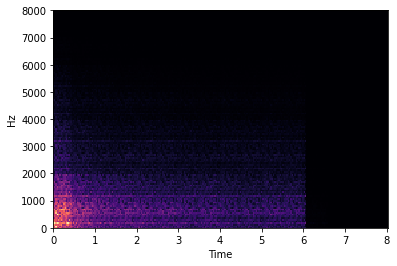

[0,   110] loss : 0.0151
[0,   120] loss : 0.0201
[0,   130] loss : 0.0210
[0,   140] loss : 0.0135
[0,   150] loss : 0.0149
[0,   160] loss : 0.0196
[0,   170] loss : 0.0176
[0,   180] loss : 0.0155
[0,   190] loss : 0.0189
[0,   200] loss : 0.0161
Val - loss : 0.0269


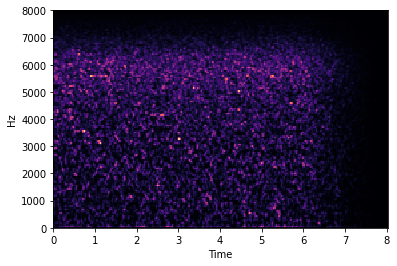

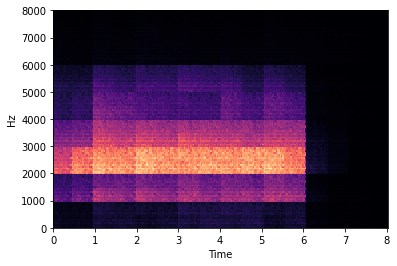

[0,   210] loss : 0.0201
[0,   220] loss : 0.0143
[0,   230] loss : 0.0225
[0,   240] loss : 0.0153
[0,   250] loss : 0.0096
[0,   260] loss : 0.0154
[0,   270] loss : 0.0173
[0,   280] loss : 0.0154
[0,   290] loss : 0.0140
[0,   300] loss : 0.0087
Val - loss : 0.0238


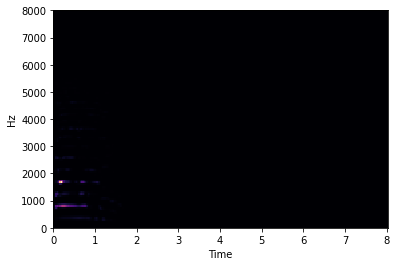

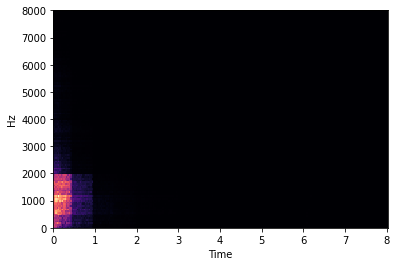

[0,   310] loss : 0.0118
[0,   320] loss : 0.0138
[0,   330] loss : 0.0145
[0,   340] loss : 0.0131
[0,   350] loss : 0.0143
[0,   360] loss : 0.0176
[0,   370] loss : 0.0142
[0,   380] loss : 0.0173
[0,   390] loss : 0.0138
[0,   400] loss : 0.0131
Val - loss : 0.0221


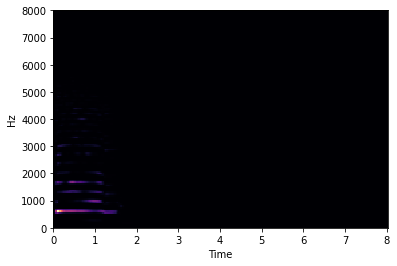

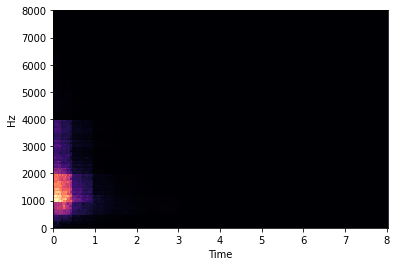

[0,   410] loss : 0.0140
[0,   420] loss : 0.0155
[0,   430] loss : 0.0144
[0,   440] loss : 0.0162
[0,   450] loss : 0.0113
[0,   460] loss : 0.0141
[0,   470] loss : 0.0145
[0,   480] loss : 0.0200
[0,   490] loss : 0.0158
[0,   500] loss : 0.0161
Val - loss : 0.0237


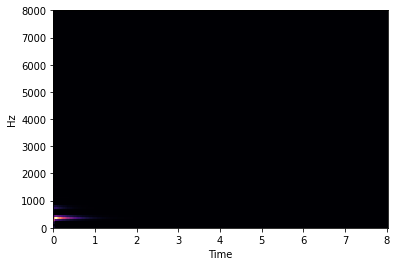

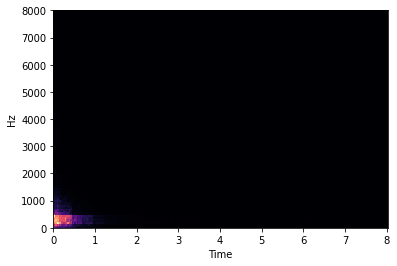

[0,   510] loss : 0.0102
[0,   520] loss : 0.0189
[0,   530] loss : 0.0155
[0,   540] loss : 0.0140
[0,   550] loss : 0.0120
[0,   560] loss : 0.0109
[0,   570] loss : 0.0143
[0,   580] loss : 0.0157
[0,   590] loss : 0.0150
[0,   600] loss : 0.0105
Val - loss : 0.0217


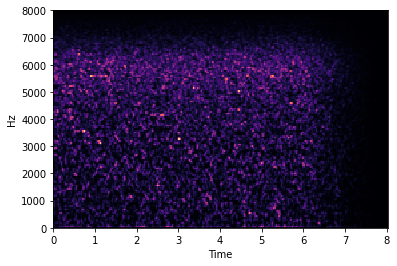

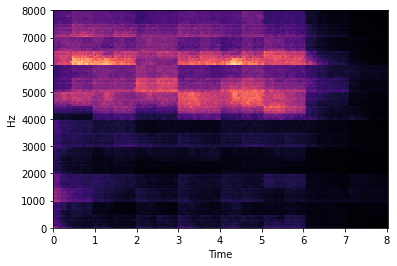

[0,   610] loss : 0.0104
[0,   620] loss : 0.0162
[0,   630] loss : 0.0153
[0,   640] loss : 0.0185
[0,   650] loss : 0.0090
[0,   660] loss : 0.0187
[0,   670] loss : 0.0125
[0,   680] loss : 0.0115
[0,   690] loss : 0.0132
[0,   700] loss : 0.0127
Val - loss : 0.0195


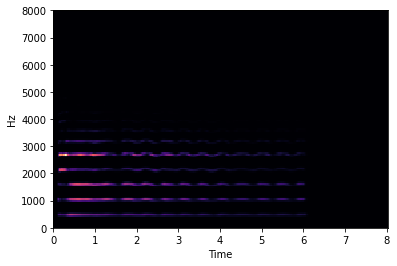

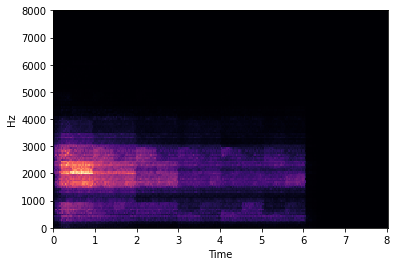

[0,   710] loss : 0.0139
[0,   720] loss : 0.0112
[0,   730] loss : 0.0101
[0,   740] loss : 0.0134
[0,   750] loss : 0.0164
[0,   760] loss : 0.0157
[0,   770] loss : 0.0135
[0,   780] loss : 0.0135
[0,   790] loss : 0.0071
[0,   800] loss : 0.0104
Val - loss : 0.0221


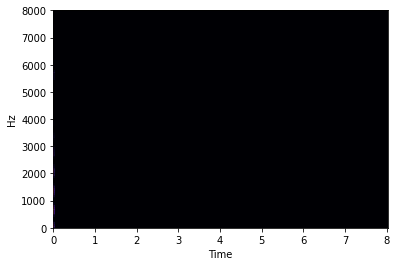

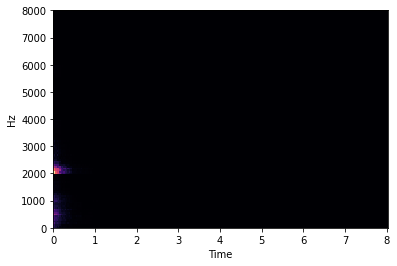

[0,   810] loss : 0.0179
[0,   820] loss : 0.0087
[0,   830] loss : 0.0100
[0,   840] loss : 0.0101
[0,   850] loss : 0.0171
[0,   860] loss : 0.0141
[0,   870] loss : 0.0119
[0,   880] loss : 0.0079
[0,   890] loss : 0.0121
[0,   900] loss : 0.0138
Val - loss : 0.0202


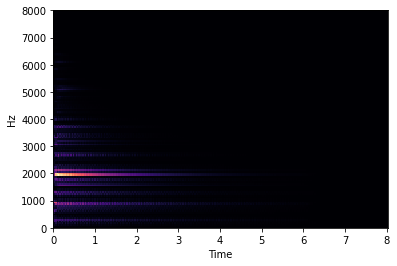

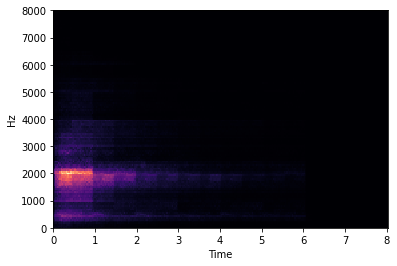

[0,   910] loss : 0.0151
[0,   920] loss : 0.0129
[0,   930] loss : 0.0108
[0,   940] loss : 0.0141
[0,   950] loss : 0.0084
[0,   960] loss : 0.0109
[0,   970] loss : 0.0118
[0,   980] loss : 0.0153
[0,   990] loss : 0.0107
[0,  1000] loss : 0.0109
Val - loss : 0.0196


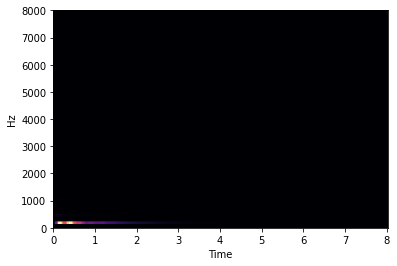

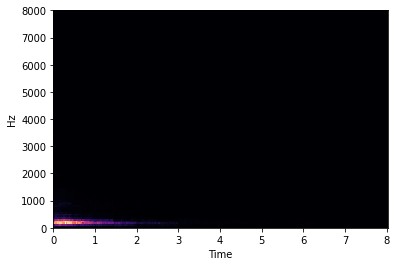

[0,  1010] loss : 0.0147
[0,  1020] loss : 0.0126
[0,  1030] loss : 0.0130
[0,  1040] loss : 0.0081
[0,  1050] loss : 0.0161
[0,  1060] loss : 0.0154
[0,  1070] loss : 0.0104
[0,  1080] loss : 0.0092
[0,  1090] loss : 0.0127
[0,  1100] loss : 0.0157
Val - loss : 0.0200


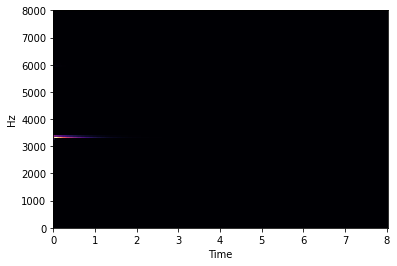

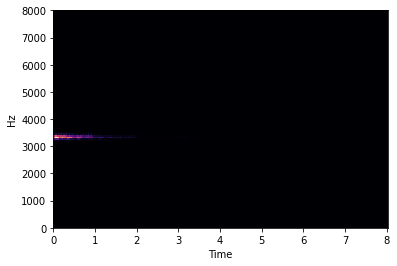

[0,  1110] loss : 0.0108
[0,  1120] loss : 0.0108
[0,  1130] loss : 0.0113
[0,  1140] loss : 0.0098
[0,  1150] loss : 0.0154
[0,  1160] loss : 0.0157
[0,  1170] loss : 0.0127
[0,  1180] loss : 0.0089
[0,  1190] loss : 0.0064
[0,  1200] loss : 0.0094
Val - loss : 0.0202


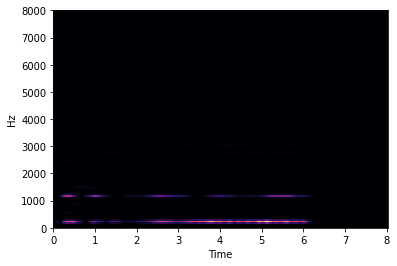

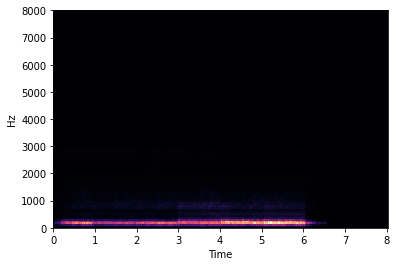

[0,  1210] loss : 0.0129
[0,  1220] loss : 0.0165
[0,  1230] loss : 0.0148
[0,  1240] loss : 0.0131
[0,  1250] loss : 0.0122
[0,  1260] loss : 0.0128
[0,  1270] loss : 0.0073
[0,  1280] loss : 0.0085
[0,  1290] loss : 0.0095
[0,  1300] loss : 0.0079
Val - loss : 0.0189


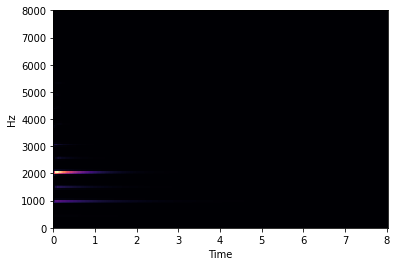

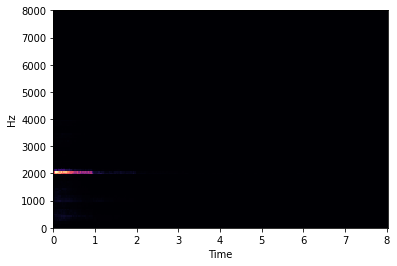

[0,  1310] loss : 0.0137
[0,  1320] loss : 0.0114
[0,  1330] loss : 0.0137
[0,  1340] loss : 0.0097
[0,  1350] loss : 0.0124
[0,  1360] loss : 0.0113
[0,  1370] loss : 0.0125
[0,  1380] loss : 0.0128
[0,  1390] loss : 0.0071
[0,  1400] loss : 0.0124
Val - loss : 0.0205


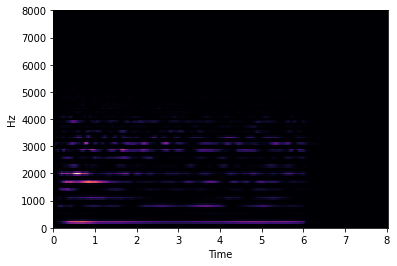

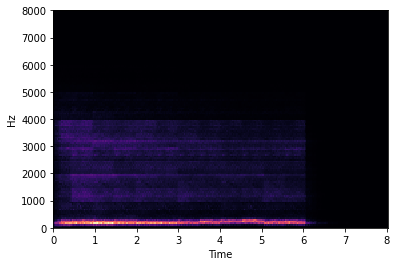

[0,  1410] loss : 0.0140
[0,  1420] loss : 0.0185
[0,  1430] loss : 0.0119
[0,  1440] loss : 0.0081
[0,  1450] loss : 0.0090
[0,  1460] loss : 0.0096
[0,  1470] loss : 0.0150
[0,  1480] loss : 0.0116
[0,  1490] loss : 0.0128
[0,  1500] loss : 0.0097
Val - loss : 0.0167


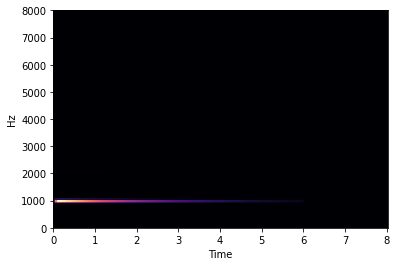

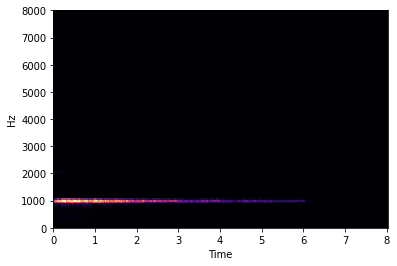

[0,  1510] loss : 0.0100
[0,  1520] loss : 0.0164
[0,  1530] loss : 0.0078
[0,  1540] loss : 0.0117
[0,  1550] loss : 0.0099
[0,  1560] loss : 0.0169


In [ ]:
loss_fn = nn.BCELoss()

ckpt_path = None
best_loss = 1e10
since_best = 0
done = False
for epoch in range(hparams['n_epochs']):
    if done:
        break
    
    itr = 0
    for batch in train_dataloader:
        if done:
            break
            
        itr += 1
        batch = batch.unsqueeze(1)
        outputs = model(batch)
        
        loss = loss_fn(outputs, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (itr % hparams['display_iters'] == 0) or (itr == 1):
            print_and_log('[{}, {:5d}] loss : {:.4f}'.format(epoch, itr, loss.item()), log_file)
            
        if itr % hparams['val_iters'] == 0:
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)
            
            model.eval()
            
            ct, i, val_loss = 0, 0, 0.0
            for batch in val_dataloader:
                i += 1
                ct += batch.size(0)
                batch = batch.unsqueeze(1)
                outputs = model(batch)
                
                loss = loss_fn(outputs, batch)
                val_loss += (loss.item() - val_loss)/i
                
                if ct >= hparams['n_val_samples']:
                    break
            
            print_and_log('Val - loss : {:.4f}'.format(val_loss), log_file)
            librosa.display.specshow(batch[0][0].numpy(), sr=16000, x_axis='time', y_axis='hz')
            plt.show()
            librosa.display.specshow(outputs[0][0].detach().numpy(), sr=16000, x_axis='time', y_axis='hz')
            plt.show()
            
            if val_loss < best_loss:
                since_best = 0
                best_loss = val_loss
                
                if ckpt_path:
                    os.remove(ckpt_path)
                ckpt_path = os.path.join(results_dir, 'model-{}.weights'.format(itr))
                torch.save(model.state_dict(), ckpt_path)
                print_and_log('Weights saved in {}'.format(ckpt_path), log_file)
            else:
                since_best += 1
                if since_best >= hparams['n_early_stopping']:
                    done = True
                    print_and_log('Early stopping... training complete', log_file)
                    
            model.train()